# Reduced FWI

This file is a demo of frequency domain FWI solved by the reduced problem.
The problem is:
$$\min_{M} J(m) = \frac{1}{2}\|P A(m)^{-1}q - d\|^2_2.$$

Here the PDE constraint is Helmholtz equation:
$$A(m) u = q.$$

To solve the problem we follow the routine of computing gradient by the adjoint method.
Blue dot is for source and orange dot is for receiver.

In [4]:
include("program/model.jl");
include("program/make_diff_op.jl")
include("program/make_projection_op.jl")
include("program/make_source_vec.jl")
include("program/compute_gradient.jl")
include("program/lbfgsb_fwi.jl")
# include("lbfgs_fwi.jl")

include("program/draw_figure.jl")

┌ Info: Recompiling stale cache file /Users/lida/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1187


draw_wavefield (generic function with 1 method)

In [ ]:
using ImageFiltering

# source and receiver
Nx = 51; Ny = 51;
dx = 20; dy = 20;
pml_len = 10;

coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = 2;
    coor_source[i,2] = i;
end

coor_receiver = ones(Int,102, 2);
for i = 1:51
    coor_receiver[i,1] = 50;
    coor_receiver[i,2] = i;
end
for i = 52:102
    coor_receiver[i,1] = 2;
    coor_receiver[i,2] = i-51;
end

model = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

# Build the velocity model
Nx_pml = model.Nx + 2*pml_len;
Ny_pml = model.Ny + 2*pml_len;

vel0 = 2000*ones(model.Nx, model.Ny);
vel = 2000*ones(model.Nx, model.Ny);
vel[21:36, :] .= 2100;
vel[37:51, :] .= 2200;
# vel[21:31, 21:31] .= 2100;
# vel0_ex = extend_vel(vel0, model, pml_len);
vel_ex = extend_vel(vel, model);
vel0_ex = imfilter(vel_ex, Kernel.gaussian(10));

vel_ex = reshape(vel_ex, Nx_pml*Ny_pml);
vel0_ex = reshape(vel0_ex, Nx_pml*Ny_pml);

# Solve the equation A(m)u = q
Pr = make_projection_op(model);
fre = 10;
A = make_diff_op(vel_ex, model, fre);
q = make_source_vec(model);

u = A \ q;|
d = Pr * u;

In [ ]:
draw_model(vel0_ex, model); title("Initial Model")

In [ ]:
draw_model(vel_ex, model); title("True Model")

In [ ]:
draw_wavefield(u, model, index=20); title("Wavefield")

In [13]:
fre_vec = [10]
result = lbfgs_fwi(vel_ex, vel0_ex, model, fre_vec; iterTime=10);

Frequency content is: [10]
Frequency is: 10 Hz
Iter     Function value   Gradient norm 
     0     6.170492e+02     1.974624e+09
     1     2.724224e+02     1.821756e+09
     2     1.307481e+02     1.668680e+09
     3     4.103937e+01     5.043640e+08
     4     2.967086e+01     7.625248e+08
     5     2.097609e+01     2.632047e+08
     6     1.775224e+01     3.785807e+08
     7     1.412867e+01     1.931876e+08
     8     9.526932e+00     2.143442e+08
     9     8.884516e+00     1.395165e+08
    10     7.463290e+00     1.313043e+08


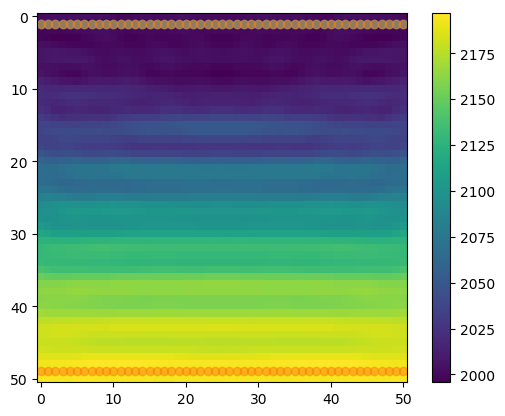

PyObject <matplotlib.collections.PathCollection object at 0x144d5fdd8>

In [14]:
draw_model(result, model)

In [4]:
using JLD2
@load "overthrust_small.jld2" vel_true vel_init
vel_true = copy(vel_true');
vel_init = copy(vel_init');

Nx, Ny = size(vel_true)
dx = 25; dy = 25
pml_len = 20;

# source and receiver
coor_source = ones(Int, 101, 2);
source = -1 .* ones(101);

for i = 1:101
    coor_source[i,1] = 2;
    coor_source[i,2] = (i-1)*4+1;
end

coor_receiver = ones(Int,101, 2);
for i = 1:101
    coor_receiver[i,1] = 2;
    coor_receiver[i,2] = (i-1)*4+1;
end

model = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel_true = extend_vel(vel_true, model);
vel_init = extend_vel(vel_init, model);
Nx_pml = model.Nx + 2*pml_len;
Ny_pml = model.Ny + 2*pml_len;
vel_true = reshape(vel_true, Nx_pml*Ny_pml,1);
vel_init = reshape(vel_init, Nx_pml*Ny_pml,1);

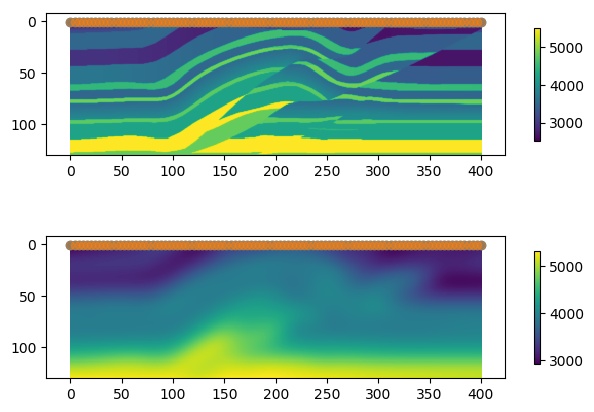

In [5]:
draw_model2(vel_true, vel_init, model)

In [24]:
# Solve the equation A(m)u = q
Pr = make_projection_op(model);
fre = 5;
A = make_diff_op(vel_true, model, fre);
q = make_source_vec(model);

@time u = A \ q;
d = Pr * u;

 11.246185 seconds (607 allocations: 1.022 GiB, 3.99% gc time)


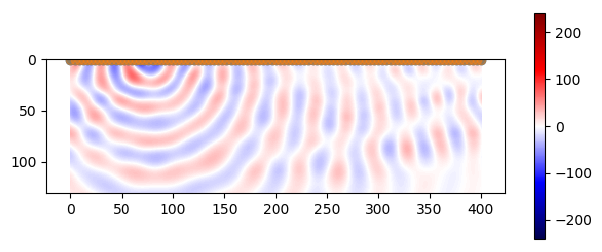

In [7]:
draw_wavefield(u, model, index=20)

In [10]:
Pre = preconditioner(vel_true, model, fre);
@time uu = (Pre*A) \ (Pre*q);

 18.285247 seconds (955.03 k allocations: 1.492 GiB, 2.84% gc time)


In [12]:
using IterativeSolvers

In [13]:
@time u = lsqr(A, q[:,20]);

107.799657 seconds (3.35 M allocations: 36.306 GiB, 5.70% gc time)


In [14]:
@time u = bicgstabl(A, q[:,20]);

 50.058340 seconds (5.27 M allocations: 32.412 GiB, 11.47% gc time)


In [ ]:
@time u = bicgstabl(A, q[:,20]);

In [ ]:
@time uu = lsqr(Pre*A, Pre*q[:,20]);

In [15]:
using Pkg
Pkg.add("IncompleteLU")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
 Installed IncompleteLU ─ v0.1.1
  Updating `~/.julia/environments/v1.0/Project.toml`
  [40713840] + IncompleteLU v0.1.1
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [40713840] + IncompleteLU v0.1.1
  [9abbd945] + Profile 


In [16]:
using IncompleteLU

┌ Info: Precompiling IncompleteLU [40713840-3770-5561-ab4c-a76e7d0d7895]
└ @ Base loading.jl:1189


In [22]:
A = sprand(1000, 1000, 5 / 1000) + 10I;
fact = @time ilu(A, τ = 0.001);

  0.249421 seconds (301.86 k allocations: 15.983 MiB, 5.49% gc time)


In [30]:
LU = ilu(real(A), τ = 0.1);
@time u = bicgstabl(A, q[:,20], 2, Pl = LU, max_mv_products = 2000, log = true);
# @time u = bicgstabl(A, q[:,20], PI=LU);

 12.526808 seconds (22.66 k allocations: 6.753 GiB, 10.16% gc time)
